# Jul 16th, 2022 (Fig-sup: Deg/Ent perc + carto + n128)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
perc = 15
fig_dir = 'Figs_Supp'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Figs_Supp

## Prepare (512)

In [3]:
num_k = 7
perc = 15
mice = Mice(nn)
bt_dict, props_bo, props_ca = default_props(mice, num_k, perc)
bt = BootStrap(**props_ca)
pal = prepare_palette()

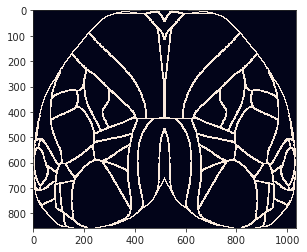

In [4]:
contour = bt.get_contour(0.2, False)
plt.imshow(contour);

## Ent/Deg percentile

In [5]:
%%time

for mode, o in bt_dict.items():
    o.compute_entropy(
        use_prune=True,
        select_seeds=False,
    )
for mode, o in bt_dict.items():
    o.run_deg = np.array(o.run_deg)
    o.run_deg[o.run_deg == 0] = np.nan

CPU times: user 9.06 s, sys: 2.69 s, total: 11.8 s
Wall time: 11.8 s


In [6]:
d = perc / 100
d

0.15

In [7]:
good = git_good('deg', bt_dict)
good.sum()

530

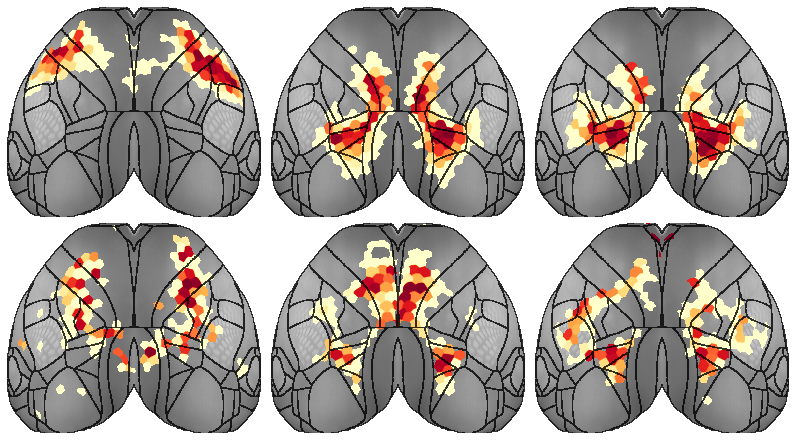

CPU times: user 4min 38s, sys: 1.42 s, total: 4min 39s
Wall time: 4min 39s


In [8]:
%%time

fig, axes = create_figure(
    nrows=2,
    ncols=3,
    figsize=(11, 6),
    tight_layout=False,
    constrained_layout=True,
)
for j, (mode, o) in enumerate(bt_dict.items()):
    # axes[0, j].set_title(mode, y=1.05, fontsize=20)
    output = o.ent_deg_percentile(
        n_resamples=int(1e5),
        mu=(0, len(o.n2l) * d),
        good=good if mode == CAF
        else None,
    )
    for i, item in enumerate(['p_deg', 'p_ent']):
        x = output[item].copy()
        x[x < 80] = np.nan
        ax = axes[i, j]

        ax = ctx2ax(
            x=x,
            ax=ax,
            base=bt,
            vmin=90,
            vmax=100,
            cbar=False,
            contour=contour,
            contour_alpha=0.8,
            contour_cmap='Greys_r',
            cmap='YlOrRd',
        )
remove_ticks(axes)
fig.savefig(pjoin(fig_dir, 'ent_deg_perc.png'), **kws_fig)
plt.show()

## Cartography

In [9]:
d = perc / 100
d

0.15

In [10]:
mu = (0, good.sum() * d)
mu

(0, 79.5)

In [11]:
df = []
for mode, o in bt_dict.items():
    _ = o.compute_entropy()
    _df = o.mk_cartography_df(
        affil=bt.affil_included,
        n_resamples=int(1e2),
        mu=mu,
    )
    _df['mode'] = mode
    df.append(_df)
df = pd.concat(df)

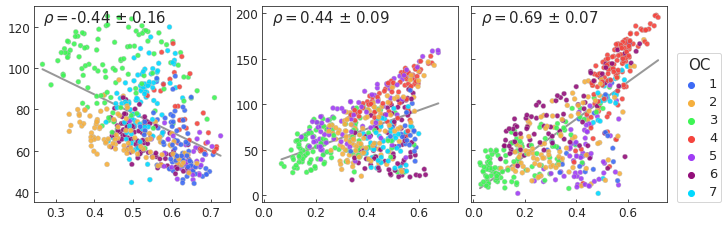

In [12]:
from figures.fig_carto import cartography as go
fig, *_ = go(df, bt_dict)

fig.savefig(pjoin(fig_dir, 'carto.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'carto.png'), **kws_fig)

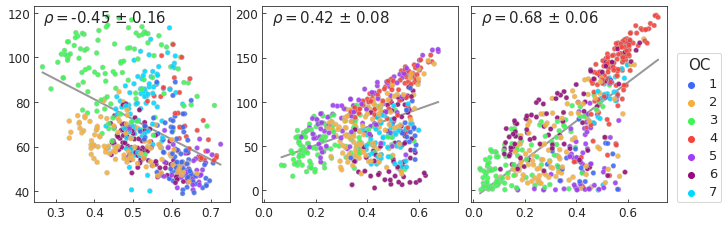

### Save disjoint to use as key

In [9]:
%%time

results = similiarity_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    n_resamples=int(1e1),
    merge_thres=0.444 if
    num_k == 7 else None,
)

CPU times: user 12.8 s, sys: 3.1 s, total: 15.9 s
Wall time: 15.9 s


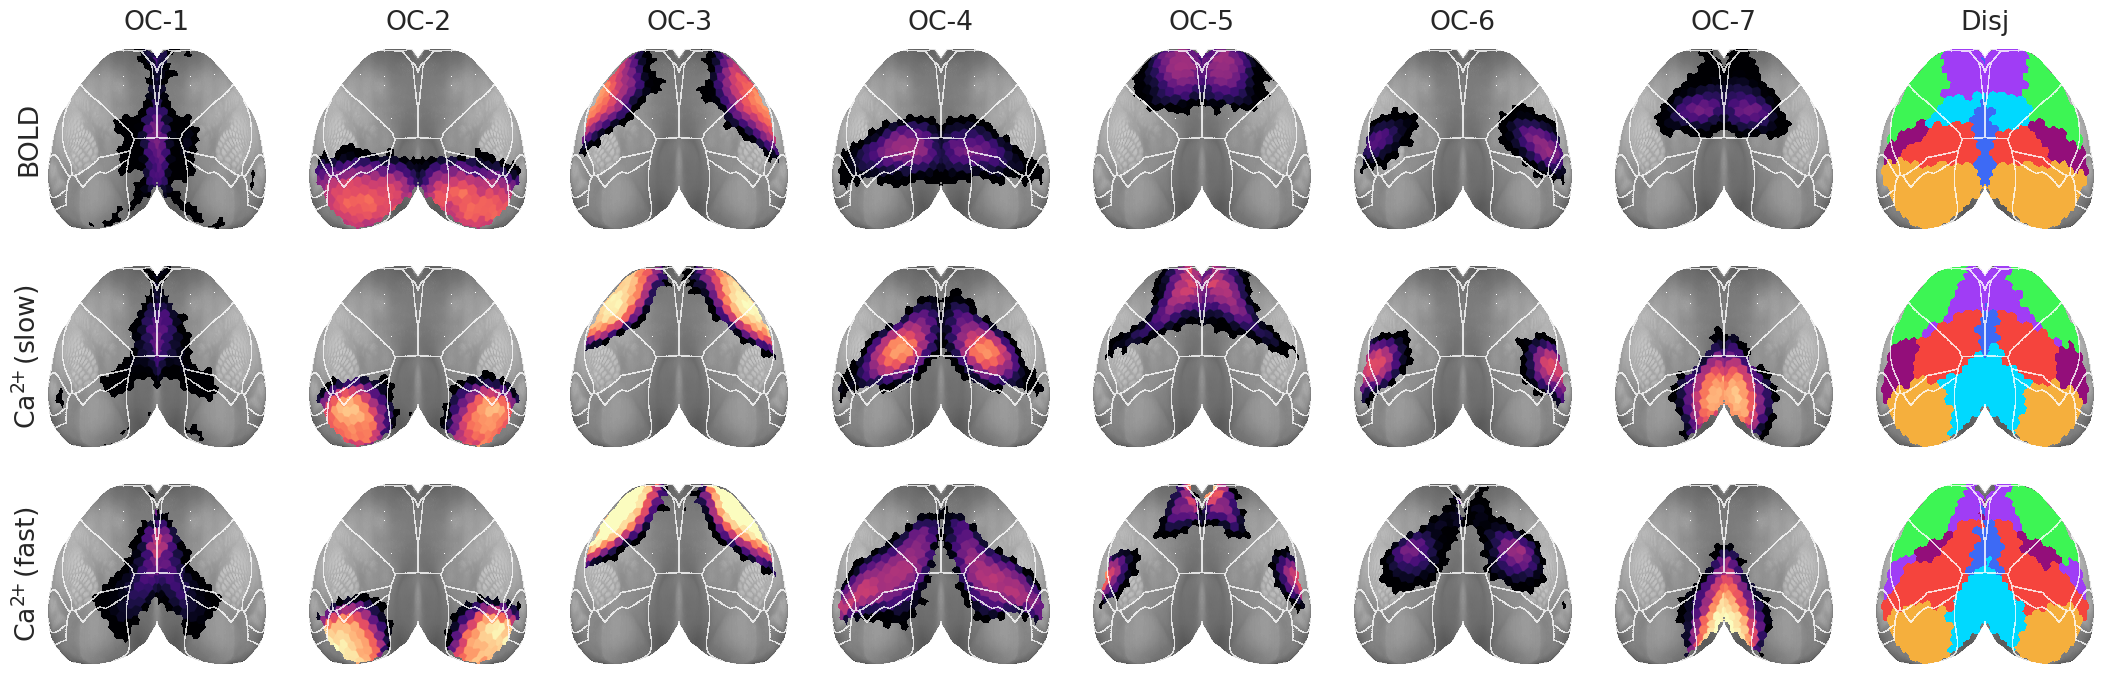

In [10]:
_ = bt.show(results['pi_sorted'], **show_kws(num_k))

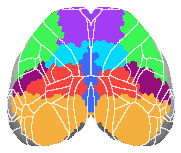

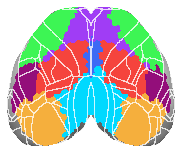

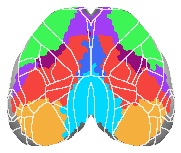

In [11]:
mode2lbl = {BOLD: 'BOLD', CAS: 'CAS', CAF: 'CAF'}
for mode, pi in results['pi_sorted'].items():
    partition = bt.get_disjoint_community(pi)

    fig, ax = create_figure(figsize=(3, 3.2))
    ax = ctx2ax(
        ax,
        bt,
        partition,
        cmap=bt.cmaps[-1],
        contour=contour,
        vmin=1,
        vmax=o.num_k,
        cbar=False,
        interp='none',
    )
    remove_ticks(ax)
    
    fig.savefig(pjoin(fig_dir, f'Disj_{mode2lbl[mode]}.png'), **kws_fig)
    plt.show()